<!-- Copyright 2023 Sidney Radcliffe

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License. -->

<!-- Warning, README.md is autogenerated from README.ipynb, do not edit it directly -->


`pip install make_agents`

[![](https://github.com/sradc/make_agents/workflows/Python%20package/badge.svg?branch=main)](https://github.com/sradc/make_agents/commits/)

<p align="center">
  <img src="README_files/make_agents_logo.jpg" width=256>
</p>

# MakeAgents

MakeAgents is a micro framework for creating LLM-driven agents, (it currently supports OpenAI's GPT chat models).

The MakeAgents paradigm is to define an agent's behaviour and capabilities through **action functions**, and an **action graph**. 

TODO: put this in a "concepts" tutorial, with examples for each:

- Action functions: capabilities of the agent, that also shape its behaviour, (can be considered as part of the prompt).
- Action graph: defines what actions the agent has access to at a given point in time. Can shape the behaviour, and e.g. make sure that certain actions have been carried out before other actions.
- Execution is carried out using a generator, which makes it easy to see and vet what the agent is doing / about to do.


## Quickstart examples

### Example 1: A conversational agent for getting the user's name

In [1]:
import json
import pprint

from pydantic import BaseModel, Field

import make_agents as ma

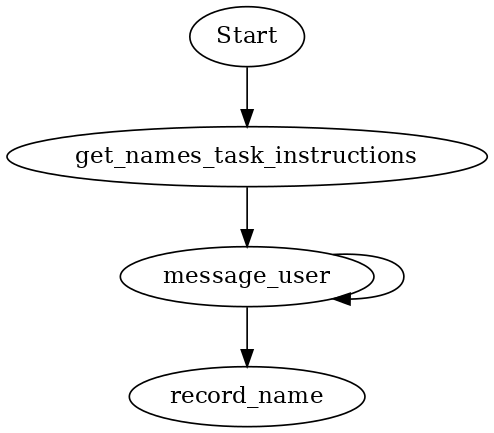

{ 'content': '"Your task is to get both the user\'s first and second name. '
             'Converse with them until you get it."',
  'name': 'get_names_task_instructions',
  'role': 'function'}

{ 'content': None,
  'function_call': { 'arguments': '{\n'
                                  '  "question": "What is your first name?"\n'
                                  '}',
                     'name': 'message_user'},
  'role': 'assistant'}

{'content': '"It\'s Bob"', 'name': 'message_user', 'role': 'function'}

{ 'content': None,
  'function_call': { 'arguments': '{\n  "next_function": "message_user"\n}',
                     'name': 'select_next_func'},
  'role': 'assistant'}

{ 'content': '{"next_function": "message_user"}',
  'name': 'select_next_func',
  'role': 'function'}

{ 'content': None,
  'function_call': { 'arguments': '{\n'
                                  '  "question": "What is your last name?"\n'
                                  '}',
                     'name': 'message

In [3]:
# Define action functions


@ma.action
def get_names_task_instructions():
    return (
        "Your task is to get both the user's first and second name. Converse with them"
        " until you get it."
    )


class MessageUserArg(BaseModel):
    question: str = Field(description="Question to ask user")


@ma.action
def message_user(arg: MessageUserArg):
    """Send the user a message, and get their response."""
    response = ""
    while response == "":
        response = input(arg.question).strip()
    return response


class LogNameArg(BaseModel):
    first_name: str = Field(description="User's first name")
    last_name: str = Field(description="User's last name")


@ma.action
def record_name(arg: LogNameArg):
    """Record the users first and last name."""
    return {"first_name": arg.first_name, "last_name": arg.last_name}


# Define action graph
action_graph = {
    ma.Start: [get_names_task_instructions],
    get_names_task_instructions: [message_user],
    message_user: [message_user, record_name],
}
display(ma.bonus.draw_graph(action_graph))

# Run the agent
for messages in ma.run_agent(action_graph):
    # `messages` contains the whole message stack, so just print the most recent message
    pprint.pprint(messages[-1], indent=2)
    print()
print(f"Retrieved user_name: {json.loads(messages[-1]['content'])}")

### Notes:

Prompting has a big impact on the performance of the agent. The `llm_func` function names, Pydantic models and docstrings can all be considered part of the prompt.

### Contributing

It's early days for the framework...

- If you have an opinion, please raise an issue / start a discussion.
- If you have created something cool, please consider contributing (will put in `community_examples`)

### Dev setup

- Clone the repo and `cd` into it
- Run `poetry install`
- Run `poetry run pre-commit install`
